关于Transformer的pytorch实现

In [38]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

In [39]:
torch.cuda.is_available()

True

# 1、数据预处理

In [40]:
# S: 起始标记
# E: 结束标记
# P：意为padding，将当前序列补齐至最长序列长度的占位符
sentence = [
    # enc_input   dec_input    dec_output
    ['ich mochte ein bier P','S i want a beer .', 'i want a beer . E'],
    ['ich mochte ein cola P','S i want a coke .', 'i want a coke . E'],
]

# 词典，padding用0来表示
# 源词典
src_vocab = {'P':0, 'ich':1,'mochte':2,'ein':3,'bier':4,'cola':5}
src_vocab_size = len(src_vocab) # 6
# 目标词典（包含特殊符）
tgt_vocab = {'P':0,'i':1,'want':2,'a':3,'beer':4,'coke':5,'S':6,'E':7,'.':8}
# 反向映射词典，idx ——> word
idx2word = {v:k for k,v in tgt_vocab.items()}
tgt_vocab_size = len(tgt_vocab) # 9

src_len = 5 # 输入序列enc_input的最长序列长度，其实就是最长的那句话的token数
tgt_len = 6 # 输出序列dec_input/dec_output的最长序列长度


In [41]:
# 这个函数把原始输入序列转换成token表示
def make_data(sentence):
    enc_inputs, dec_inputs, dec_outputs = [],[],[]
    for i in range(len(sentence)):
        enc_input = [src_vocab[word] for word in sentence[i][0].split()]
        dec_input = [tgt_vocab[word] for word in sentence[i][1].split()]
        dec_output = [tgt_vocab[word] for word in sentence[i][2].split()]
        
        enc_inputs.append(enc_input)
        dec_inputs.append(dec_input)
        dec_outputs.append(dec_output)
        
    # LongTensor是专用于存储整型的，Tensor则可以存浮点、整数、bool等多种类型
    return torch.LongTensor(enc_inputs),torch.LongTensor(dec_inputs),torch.LongTensor(dec_outputs)

enc_inputs, dec_inputs, dec_outputs = make_data(sentence)

print(' enc_inputs: \n', enc_inputs)  # enc_inputs: [2,5]
print(' dec_inputs: \n', dec_inputs)  # dec_inputs: [2,6]
print(' dec_outputs: \n', dec_outputs) # dec_outputs: [2,6]

 enc_inputs: 
 tensor([[1, 2, 3, 4, 0],
        [1, 2, 3, 5, 0]])
 dec_inputs: 
 tensor([[6, 1, 2, 3, 4, 8],
        [6, 1, 2, 3, 5, 8]])
 dec_outputs: 
 tensor([[1, 2, 3, 4, 8, 7],
        [1, 2, 3, 5, 8, 7]])


In [42]:
# 使用Dataset加载数据
class MyDataSet(Data.Dataset):
    def __init__(self,enc_inputs, dec_inputs, dec_outputs):
        super(MyDataSet,self).__init__()
        self.enc_inputs = enc_inputs
        self.dec_inputs = dec_inputs
        self.dec_outputs = dec_outputs
        
    def __len__(self):
        # 我们前面的enc_inputs.shape = [2,5],所以这个返回的是2
        return self.enc_inputs.shape[0] 
    
    # 根据idx返回的是一组 enc_input, dec_input, dec_output
    def __getitem__(self, idx):
        return self.enc_inputs[idx], self.dec_inputs[idx], self.dec_outputs[idx]

# 构建DataLoader
loader = Data.DataLoader(dataset=MyDataSet(enc_inputs,dec_inputs, dec_outputs),batch_size=2,shuffle=True)


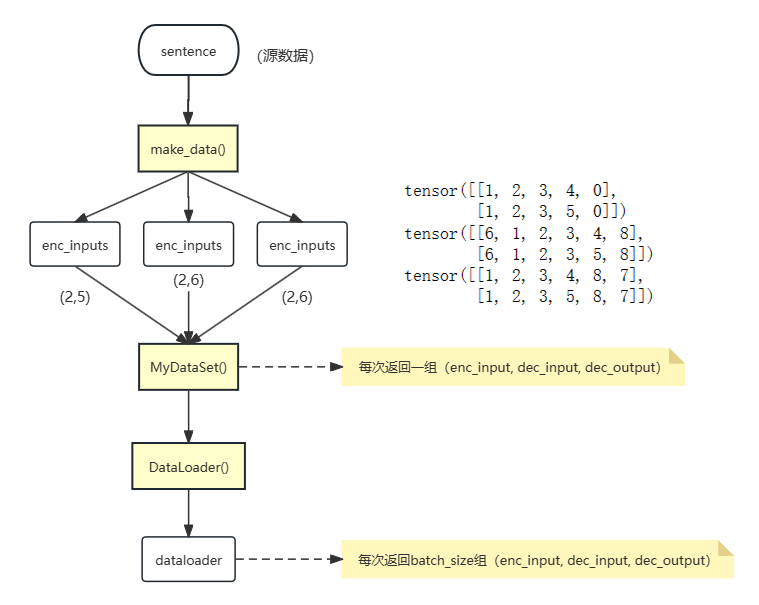

# 2、模型参数


In [43]:
# 用来表示一个词的向量长度
d_model = 512

# FFN的隐藏层神经元个数
d_ff = 2048

# 分头后的q、k、v词向量长度，依照原文我们都设为64
# 原文：queries and kes of dimention d_k,and values of dimension d_v .所以q和k的长度都用d_k来表示
d_k = d_v = 64

# Encoder Layer 和 Decoder Layer的个数
n_layers = 6

# 多头注意力中head的个数，原文：we employ h = 8 parallel attention layers, or heads
n_heads = 8

- Transformer包含Encoder和Decoder
- Encoder和Decoder各自包含6个Layer
- Encoder Layer中包含 Self Attention 和 FFN 两个Sub Layer
- Decoder Layer中包含 Masked Self Attention、 Cross Attention、 FFN 三个Sub Layer

- 布局如图：
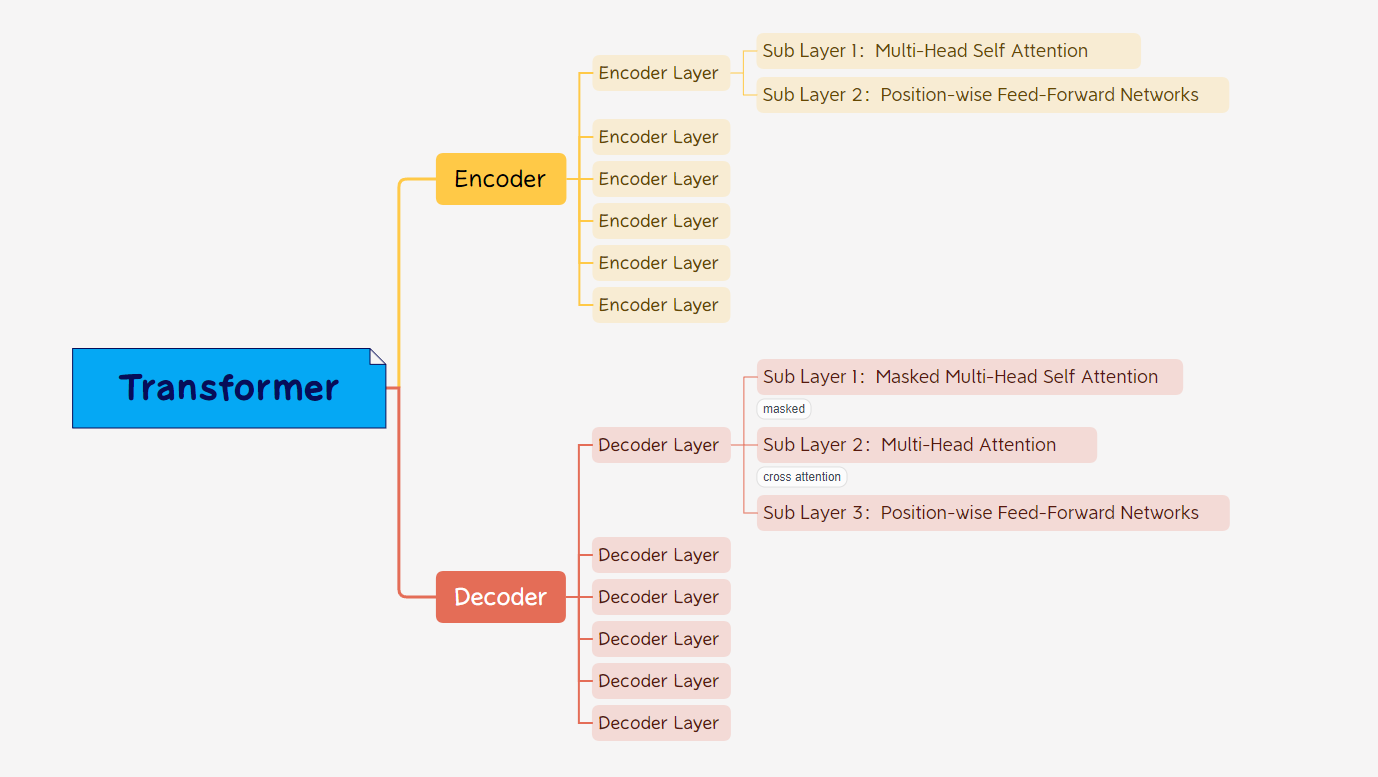

# 3、Positional Encoding

> 用于为输入的词向量进行位置编码

原文：The positional encodings have the same dimension d_model as the embeddings, so that the two can be summed

In [44]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000): # dropout是原文的0.1，max_len原文没找到
        '''max_len是假设的一个句子最多包含5000个token'''
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # 开始位置编码部分,先生成一个max_len * d_model 的矩阵，即5000 * 512
        # 5000是一个句子中最多的token数，512是一个token用多长的向量来表示，5000*512这个矩阵用于表示一个句子的信息
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # pos：[max_len,1],即[5000,1]
        # 先把括号内的分式求出来,pos是[5000,1],分母是[256],通过广播机制相乘后是[5000,256]
        div_term = pos / pow(10000.0,torch.arange(0, d_model, 2).float() / d_model)
        # 再取正余弦
        pe[:, 0::2] = torch.sin(div_term)
        pe[:, 1::2] = torch.cos(div_term)
        # 一个句子要做一次pe，一个batch中会有多个句子，所以增加一维用来和输入的一个batch的数据相加时做广播
        pe = pe.unsqueeze(0) # [5000,512] -> [1,5000,512] 
        # 将pe作为固定参数保存到缓冲区，不会被更新
        self.register_buffer('pe', pe)
        
        
    def forward(self, x):
        '''x: [batch_size, seq_len, d_model]'''
        # 5000是我们预定义的最大的seq_len，就是说我们把最多的情况pe都算好了，用的时候用多少就取多少
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x) # return: [batch_size, seq_len, d_model], 和输入的形状相同
        

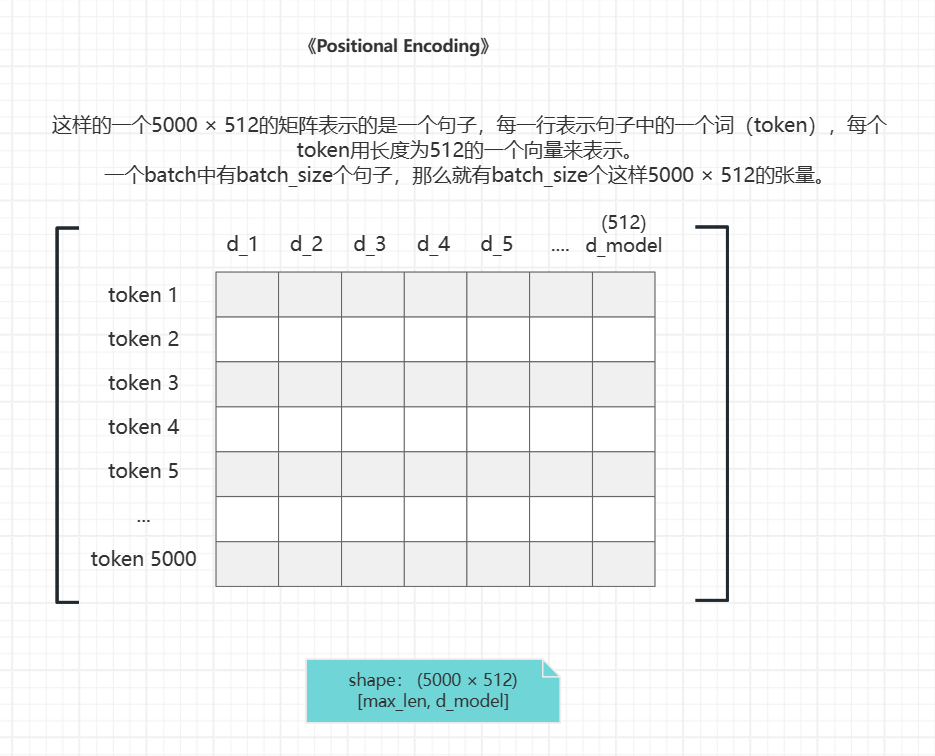


# 4、Pad Mask

- 首先我们要清楚，这是一个计算mask的函数，它的返回是一个布尔矩阵，为True的位置是需要被mask掉的，False的位置是不需要动的
- 其次这个函数是理解Transformer代码中非常重要的一环，因为我们输入模型的句子有长有短，我们用占位符P统一补足成了最长的那个句子的长度，而这些占位符是没有意义的，不能让他们吸收到query的注意力，因此我们要把这些位置设为True
- 这个计算出的mask在何时被使用呢？
    - 在query和key的转置相乘得出（len_q,len_k）这个注意力分数矩阵以后，将使用本函数得到的mask来掩盖相乘结果矩阵
    - 原来的相乘结果矩阵（len_q,len_k）中第 i 行第 j 列的意义是“作为q的序列中第i个词对作为k的序列中第j个词的注意力分数”，而第 i 整行就是q中这个词对k中所有词的注意力，第 j 整列就是q中所有词对k中第j个词的注意力分数，作为padding，q中的所有词都不应该注意它，因此对应列均需设为True
- 为什么只有k的padding位被mask了，q的padding位为什么没被mask？（即此函数的返回矩阵为什么只有最后几列是True，最后几行不应该也是True么）
    - 按理来说是这样的，作为padding不该被别人注意，同时它也不该注意别人，计算出的padding对其他词的注意力也是无意义的，我们这里其实是偷了个懒，但这是因为：q中的padding对k中的词的注意力我们是不会用到的，因为我们不会用一个padding字符去预测下一个词，并且它的向量表示不管怎么更新都不会影响到别的q中别的词的计算，所以我们就放任自流了。但k中的padding不一样，如果不管它将无意义的吸收掉大量q中词汇的注意力，使得模型的学习出现偏差。
    - p.s. 哈佛团队也是这么实现的


In [45]:
# 为enc_input和dec_input做一个mask，把占位符P的token（就是0） mask掉
# 返回一个[batch_size, len_q, len_k]大小的布尔张量，True是需要mask掉的位置
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # seq_k.data.eq(0)返回一个等大的布尔张量，seq_k元素等于0的位置为True,否则为False
    # 然后扩维以保证后续操作的兼容(广播)
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1) # pad_attn_mask: [batch_size,1,len_k]
    # 要为每一个q提供一份k，所以把第二维度扩展了q次
    # 另注意expand并非真正加倍了内存，只是重复了引用，对任意引用的修改都会修改原始值
    # 这里是因为我们不会修改这个mask所以用它来节省内存
    return pad_attn_mask.expand(batch_size, len_q, len_k) # return: [batch_size, len_q, len_k]
    # 返回的是batch_size个 len_q * len_k的矩阵，内容是True和False，
    # 第i行第j列表示的是query的第i个词对key的第j个词的注意力是否无意义，若无意义则为True，有意义的为False（即被padding的位置是True）

# 5、Subsequence Mask

> 此函数对应Transformer模型架构中Decoder的第一个注意力“Masked Multi-Head self Attention”中的Masked一词，作用是防止模型看到未来时刻的输入
- 怎么理解呢？
  - 其实这需要结合实际使用模型进行预测时的数据流动来理解（可以参考本文最后一部分的测试流程图），因为实际的预测中解码器Decoder其实是一个词一个词累积着的输出的(每次比上回多一个)，每输出一个词就会把这个词拼到新的dec_input中，然后再预测下一个词，直到输出终止标记，这是测试过程。而在训练过程中，我们为了能让模型学到最精确的表示，每一回我们喂给decoder的都是完整的正确答案，即正确翻译后的句子，但是我们的模型必须遵循真实的使用场景，所以我们需要让decoder只看到当前时刻以前的输出（即正确答案不能多看，最多看到当前这个题的就行了），而实现这一目的的方法就是：屏蔽掉当前时刻以后的注意力分数，而这个时间上“以后”的概念，体现在数据上就是序列中token的前后顺序，所以当前token之后的都需要被mask。
  - 也可以另一个角度来理解，我们的dec_input是一个完整的句子，包含翻译后的所有token，self attention的形状是tgt_len × tgt_len，但是对于第i个token来说，它不应该看到第i+1个以及更后面的token，因为按理来说后面的还没生成呢，所以他不应该对这些还不存在的token计算注意力，所以：token i 对应的这一行，token i 列之后的列都需要被mask

In [46]:
# 用于获取对后续位置的掩码，防止在预测过程中看到未来时刻的输入
# 原文：to prevent positions from attending to subsequent positions
def get_attn_subsequence_mask(seq):
    """seq: [batch_size, tgt_len]"""
    # batch_size个 tgt_len * tgt_len的mask矩阵
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    # np.triu 是生成一个 upper triangular matrix 上三角矩阵，k是相对于主对角线的偏移量
    # k=1意为不包含主对角线（从主对角线向上偏移1开始）
    subsequence_mask = np.triu(np.ones(attn_shape), k=1)
    subsequence_mask = torch.from_numpy(subsequence_mask).byte() # 因为只有0、1所以用byte节省内存
    return subsequence_mask  # return: [batch_size, tgt_len, tgt_len]
   

因为这个mask只用于解码器中的第一个self attention，q和k都是自己（dec_input），所以是一个方阵
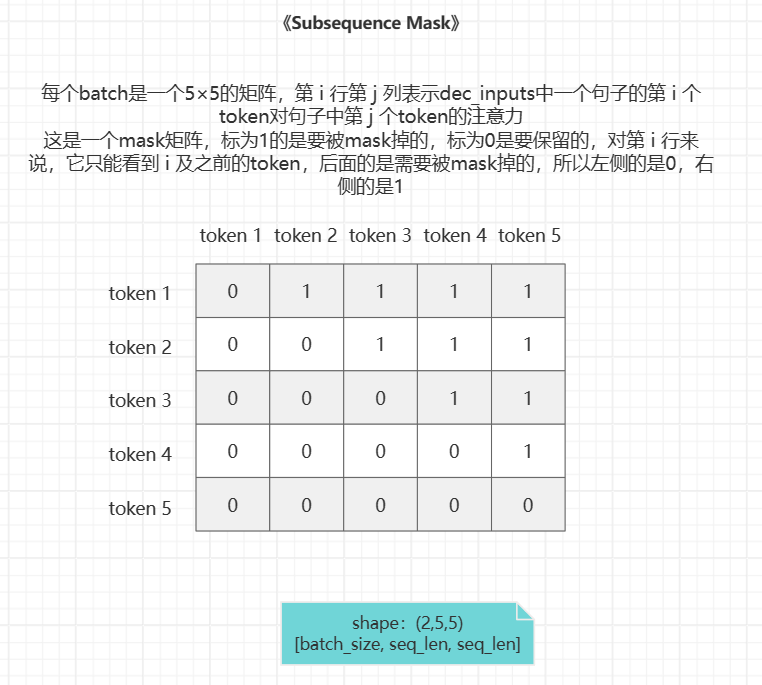

# 6、ScaledDotProductAttention
> 此函数用于计算缩放点积注意力，在MultiHeadAttention中被调用

In [47]:
class ScaledDotProductionAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductionAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        '''
        Q: [batch_size, n_heads, len_q, d_k]
        K: [batch_size, n_heads, len_k, d_k]
        V: [batch_size, n_heads, len_v(=len_k), d_v] 全文两处用到注意力，一处是self attention，另一处是co attention，前者不必说，后者的k和v都是encoder的输出，所以k和v的形状总是相同的
        attn_mask: [batch_size, n_heads, seq_len, seq_len]
        '''
        # 1) 计算注意力分数QK^T/sqrt(d_k)
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k)  # scores: [batch_size, n_heads, len_q, len_k]
        # 2)  进行 mask 和 softmax
        # mask为True的位置会被设为-1e9
        scores.masked_fill_(attn_mask, -1e9)
        attn = nn.Softmax(dim=-1)(scores)  # attn: [batch_size, n_heads, len_q, len_k]
        # 3) 乘V得到最终的加权和
        context = torch.matmul(attn, V)  # context: [batch_size, n_heads, len_q, d_v]
        '''
        得出的context是每个维度(d_1-d_v)都考虑了在当前维度(这一列)当前token对所有token的注意力后更新的新的值，
        换言之每个维度d是相互独立的，每个维度考虑自己的所有token的注意力，所以可以理解成1列扩展到多列

        返回的context: [batch_size, n_heads, len_q, d_v]本质上还是batch_size个句子，
        只不过每个句子中词向量维度512被分成了8个部分，分别由8个头各自看一部分，每个头算的是整个句子(一列)的512/8=64个维度，最后按列拼接起来
        '''
        return context # context: [batch_size, n_heads, len_q, d_v]

# 7、MultiHeadAttention
> 多头注意力的实现，Transformer的核心

In [48]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.concat = nn.Linear(d_model, d_model)

    def forward(self, input_Q, input_K, input_V, attn_mask):
        '''
        input_Q: [batch_size, len_q, d_model] len_q是作为query的句子的长度，比如enc_inputs（2,5,512）作为输入，那句子长度5就是len_q
        input_K: [batch_size, len_k, d_model]
        input_K: [batch_size, len_v(len_k), d_model]
        attn_mask: [batch_size, seq_len, seq_len]
        '''
        residual, batch_size = input_Q, input_Q.size(0)

        # 1）linear projection [batch_size, seq_len, d_model] ->  [batch_size, n_heads, seq_len, d_k/d_v]
        Q = self.W_Q(input_Q).view(batch_size, -1, n_heads, d_k).transpose(1, 2) # Q: [batch_size, n_heads, len_q, d_k]
        K = self.W_K(input_K).view(batch_size, -1, n_heads, d_k).transpose(1, 2) # K: [batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, n_heads, d_v).transpose(1, 2) # V: [batch_size, n_heads, len_v(=len_k), d_v]

        # 2）计算注意力
        # 自我复制n_heads次，为每个头准备一份mask
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)  # attn_mask: [batch_size, n_heads, seq_len, seq_len]
        context = ScaledDotProductionAttention()(Q, K, V, attn_mask) # context: [batch_size, n_heads, len_q, d_v]

        # 3）concat部分
        context = torch.cat([context[:,i,:,:] for i in range(context.size(1))], dim=-1)
        output = self.concat(context)  # [batch_size, len_q, d_model]
        return nn.LayerNorm(d_model).cuda()(output + residual)  # output: [batch_size, len_q, d_model]

        '''        
        最后的concat部分，网上的大部分实现都采用的是下面这种方式（也是哈佛NLP团队的写法）
        context = context.transpose(1, 2).reshape(batch_size, -1, d_model)
        output = self.linear(context)
        但是我认为这种方式拼回去会使原来的位置乱序，于是并未采用这种写法，两种写法最终的实验结果是相近的
        '''

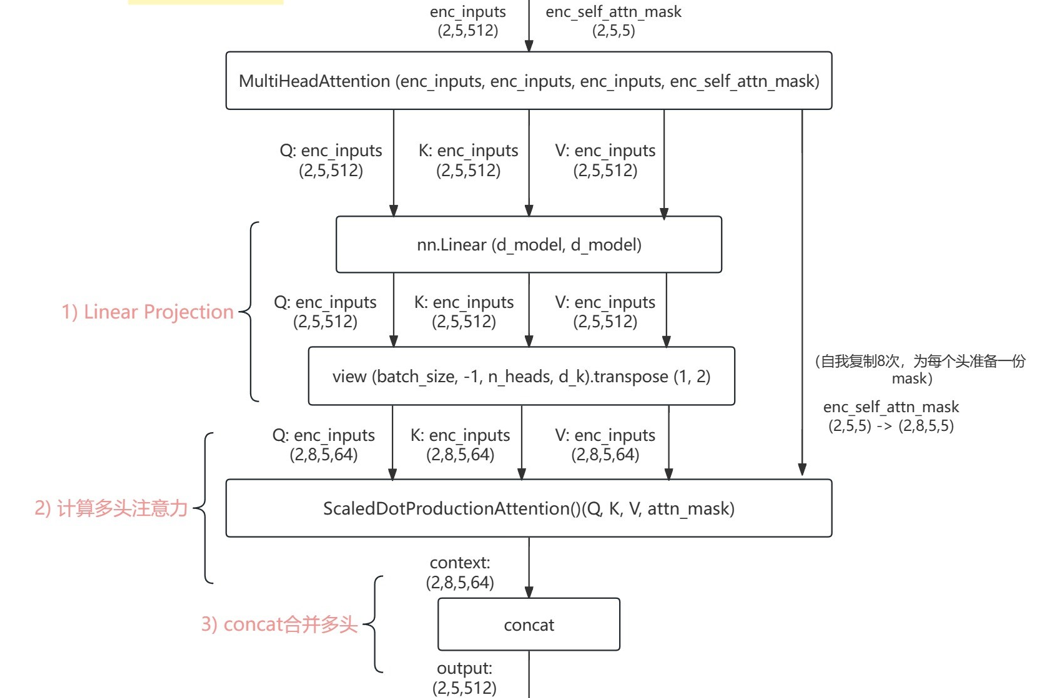

# 8、FeedForward Networks
> 这部分代码很简单，对应模型图中的 Feed Forward和 Add & Norm

In [49]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self):
        super(PositionwiseFeedForward, self).__init__()
        # 就是一个MLP
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, inputs):
        '''inputs: [batch_size, seq_len, d_model]'''
        residual = inputs
        output = self.fc(inputs)
        return nn.LayerNorm(d_model).cuda()(output + residual) # return： [batch_size, seq_len, d_model] 形状不变

# 9、Encoder Layer
> 包含一个MultiHeadAttention和一个FFN

In [50]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PositionwiseFeedForward()

    def forward(self, enc_inputs, enc_self_attn_mask):
        '''
        enc_inputs: [batch_size, src_len, d_model]
        enc_self_attn_mask: [batch_size, src_len, src_len]
        '''
        # Q、K、V均为 enc_inputs
        enc_ouputs = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_ouputs: [batch_size, src_len, d_model]
        enc_ouputs = self.pos_ffn(enc_ouputs) # enc_outputs: [batch_size, src_len, d_model]
        return enc_ouputs  # enc_outputs: [batch_size, src_len, d_model]

# 10、Encoder
> 包含一个源序列词向量嵌入nn.Embedding、一个位置编码PositionalEncoding和6个Encoder Layer

In [51]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # 直接调的现成接口完成词向量的编码，输入是类别数和每一个类别要映射成的向量长度
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs):
        '''enc_inputs: [batch_size, src_len]'''
        enc_outputs = self.src_emb(enc_inputs) # [batch_size, src_len] -> [batch_size, src_len, d_model]
        enc_outputs = self.pos_emb(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
        # Encoder中是self attention，所以传入的Q、K都是enc_inputs
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)  # enc_self_attn_mask: [batch_size, src_len, src_len]
        for layer in self.layers:
            enc_outputs = layer(enc_outputs, enc_self_attn_mask)
        return enc_outputs  # enc_outputs: [batch_size, src_len, d_model]

# 11、DecoderLayer
> 包含两个MultiHeadAttention和一个FFN

In [52]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PositionwiseFeedForward()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        '''
        dec_inputs: [batch_size, tgt_len, d_model]
        enc_outputs: [batch_size, src_len, d_model]
        dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
        dec_enc_attn_mask: [batch_size, tgt_len, src_len] 前者是Q后者是K
        '''
        dec_outputs = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)

        return dec_outputs # dec_outputs: [batch_size, tgt_len, d_model]

# 12、Decoder
> 包含一个目标序列词向量序列嵌入nn.Embedding、一个位置编码PositionalEncoding还有6个Decoder Layer

In [53]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])


    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        '''
        这三个参数对应的不是Q、K、V，dec_inputs是Q，enc_outputs是K和V，enc_inputs是用来计算padding mask的
        dec_inputs: [batch_size, tgt_len]
        enc_inpus: [batch_size, src_len]
        enc_outputs: [batch_size, src_len, d_model]
        '''
        dec_outputs = self.tgt_emb(dec_inputs)
        dec_outputs = self.pos_emb(dec_outputs).cuda()
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs).cuda()
        dec_self_attn_subsequence_mask = get_attn_subsequence_mask(dec_inputs).cuda()
        # 将两个mask叠加，布尔值可以视为0和1，和大于0的位置是需要被mask掉的，赋为True，和为0的位置是有意义的为False
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask +
                                       dec_self_attn_subsequence_mask), 0).cuda()
        # 这是co-attention部分，为啥传入的是enc_inputs而不是enc_outputs呢
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)

        for layer in self.layers:
            dec_outputs = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)

        return dec_outputs # dec_outputs: [batch_size, tgt_len, d_model]

# 13、Transformer
> 包含一个Encoder、一个Decoder、一个nn.Linear

In [54]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder().cuda()
        self.decoder = Decoder().cuda()
        self.projection = nn.Linear(d_model, tgt_vocab_size).cuda()

    def forward(self, enc_inputs, dec_inputs):
        '''
        enc_inputs: [batch_size, src_len]
        dec_inputs: [batch_size, tgt_len]
        '''
        enc_outputs = self.encoder(enc_inputs)
        dec_outputs = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs) # dec_logits: [batch_size, tgt_len, tgt_vocab_size]

        # 解散batch，一个batch中有batch_size个句子，每个句子有tgt_len个词（即tgt_len行），
        # 现在让他们按行依次排布，如前tgt_len行是第一个句子的每个词的预测概率，
        # 再往下tgt_len行是第二个句子的，一直到batch_size * tgt_len行
        return dec_logits.view(-1, dec_logits.size(-1))  #  [batch_size * tgt_len, tgt_vocab_size]
        '''最后变形的原因是：nn.CrossEntropyLoss接收的输入的第二个维度必须是类别'''

# 14、训练

In [55]:
model = Transformer().cuda()
model.train()
# 损失函数,忽略为0的类别不对其计算loss（因为是padding无意义）
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)

# 训练开始
for epoch in range(1000):
    for enc_inputs, dec_inputs, dec_outputs in loader:
        '''
        enc_inputs: [batch_size, src_len] [2,5]
        dec_inputs: [batch_size, tgt_len] [2,6]
        dec_outputs: [batch_size, tgt_len] [2,6]
        '''
        enc_inputs, dec_inputs, dec_outputs = enc_inputs.cuda(), dec_inputs.cuda(), dec_outputs.cuda()
        outputs = model(enc_inputs, dec_inputs) # outputs: [batch_size * tgt_len, tgt_vocab_size]
        # outputs: [batch_size * tgt_len, tgt_vocab_size], dec_outputs: [batch_size, tgt_len]
        loss = criterion(outputs, dec_outputs.view(-1))  # 将dec_outputs展平成一维张量

        # 更新权重
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch + 1}/1000], Loss: {loss.item()}')

torch.save(model, 'MyTransformer.pth')

Epoch [1/1000], Loss: 2.1738522052764893
Epoch [2/1000], Loss: 2.0738959312438965
Epoch [3/1000], Loss: 1.9049569368362427
Epoch [4/1000], Loss: 1.5952812433242798
Epoch [5/1000], Loss: 1.3922237157821655
Epoch [6/1000], Loss: 1.2176579236984253
Epoch [7/1000], Loss: 0.9465160965919495
Epoch [8/1000], Loss: 0.7412980198860168
Epoch [9/1000], Loss: 0.5801363587379456
Epoch [10/1000], Loss: 0.3842979967594147
Epoch [11/1000], Loss: 0.3041044771671295
Epoch [12/1000], Loss: 0.2556421756744385
Epoch [13/1000], Loss: 0.20368236303329468
Epoch [14/1000], Loss: 0.16083011031150818
Epoch [15/1000], Loss: 0.12274201959371567
Epoch [16/1000], Loss: 0.1058095172047615
Epoch [17/1000], Loss: 0.08600452542304993
Epoch [18/1000], Loss: 0.0953531563282013
Epoch [19/1000], Loss: 0.06146952509880066
Epoch [20/1000], Loss: 0.06085418537259102
Epoch [21/1000], Loss: 0.0628001019358635
Epoch [22/1000], Loss: 0.04913059249520302
Epoch [23/1000], Loss: 0.05219602212309837
Epoch [24/1000], Loss: 0.0465806387

Epoch [185/1000], Loss: 8.643512410344556e-05
Epoch [186/1000], Loss: 7.210308831417933e-05
Epoch [187/1000], Loss: 0.00013664081052411348
Epoch [188/1000], Loss: 6.081220635678619e-05
Epoch [189/1000], Loss: 8.434738992946222e-05
Epoch [190/1000], Loss: 3.749967072508298e-05
Epoch [191/1000], Loss: 5.360117575037293e-05
Epoch [192/1000], Loss: 5.589595821220428e-05
Epoch [193/1000], Loss: 6.632276199525222e-05
Epoch [194/1000], Loss: 4.485028694034554e-05
Epoch [195/1000], Loss: 6.42965969746001e-05
Epoch [196/1000], Loss: 4.984675251762383e-05
Epoch [197/1000], Loss: 4.3131218262715265e-05
Epoch [198/1000], Loss: 3.518546509440057e-05
Epoch [199/1000], Loss: 4.268478733138181e-05
Epoch [200/1000], Loss: 3.738067971426062e-05
Epoch [201/1000], Loss: 7.119199290173128e-05
Epoch [202/1000], Loss: 4.6101918997010216e-05
Epoch [203/1000], Loss: 5.6332599342567846e-05
Epoch [204/1000], Loss: 4.83666080981493e-05
Epoch [205/1000], Loss: 3.071520404773764e-05
Epoch [206/1000], Loss: 6.399136

Epoch [364/1000], Loss: 1.9877543309121393e-05
Epoch [365/1000], Loss: 2.4397348170168698e-05
Epoch [366/1000], Loss: 1.6947158655966632e-05
Epoch [367/1000], Loss: 1.786114262358751e-05
Epoch [368/1000], Loss: 2.563898488006089e-05
Epoch [369/1000], Loss: 2.3702050384599715e-05
Epoch [370/1000], Loss: 1.229820463777287e-05
Epoch [371/1000], Loss: 2.5926821763277985e-05
Epoch [372/1000], Loss: 2.3930455427034758e-05
Epoch [373/1000], Loss: 2.0791610950254835e-05
Epoch [374/1000], Loss: 2.6900575903709978e-05
Epoch [375/1000], Loss: 1.9043094653170556e-05
Epoch [376/1000], Loss: 1.671874815656338e-05
Epoch [377/1000], Loss: 2.0016632333863527e-05
Epoch [378/1000], Loss: 1.7662385289440863e-05
Epoch [379/1000], Loss: 1.6351174053852446e-05
Epoch [380/1000], Loss: 1.9261937268311158e-05
Epoch [381/1000], Loss: 1.2814849469577894e-05
Epoch [382/1000], Loss: 1.2198896911286283e-05
Epoch [383/1000], Loss: 1.0222050150332507e-05
Epoch [384/1000], Loss: 2.09902227652492e-05
Epoch [385/1000], L

Epoch [541/1000], Loss: 8.50353444548091e-06
Epoch [542/1000], Loss: 1.054000313160941e-05
Epoch [543/1000], Loss: 5.741888799093431e-06
Epoch [544/1000], Loss: 7.063114026095718e-06
Epoch [545/1000], Loss: 7.152517810027348e-06
Epoch [546/1000], Loss: 8.066450391197577e-06
Epoch [547/1000], Loss: 8.116116077871993e-06
Epoch [548/1000], Loss: 7.986978744156659e-06
Epoch [549/1000], Loss: 6.755159120075405e-06
Epoch [550/1000], Loss: 1.5199008885247167e-05
Epoch [551/1000], Loss: 9.318119737145025e-06
Epoch [552/1000], Loss: 8.026706382224802e-06
Epoch [553/1000], Loss: 1.1374460882507265e-05
Epoch [554/1000], Loss: 5.990241788822459e-06
Epoch [555/1000], Loss: 1.0122771527676377e-05
Epoch [556/1000], Loss: 9.626074643165339e-06
Epoch [557/1000], Loss: 1.1702278243319597e-05
Epoch [558/1000], Loss: 1.182147843792336e-05
Epoch [559/1000], Loss: 7.619409643666586e-06
Epoch [560/1000], Loss: 9.079696610569954e-06
Epoch [561/1000], Loss: 8.63267996464856e-06
Epoch [562/1000], Loss: 6.725362

Epoch [719/1000], Loss: 9.288331057177857e-06
Epoch [720/1000], Loss: 4.9173672778124455e-06
Epoch [721/1000], Loss: 8.205521226045676e-06
Epoch [722/1000], Loss: 4.361059382063104e-06
Epoch [723/1000], Loss: 6.566415777342627e-06
Epoch [724/1000], Loss: 8.086314664979e-06
Epoch [725/1000], Loss: 5.076310117146932e-06
Epoch [726/1000], Loss: 7.0730498009652365e-06
Epoch [727/1000], Loss: 6.1491832639148924e-06
Epoch [728/1000], Loss: 4.390859885461396e-06
Epoch [729/1000], Loss: 3.864357950078556e-06
Epoch [730/1000], Loss: 7.162454949138919e-06
Epoch [731/1000], Loss: 6.4869436755543575e-06
Epoch [732/1000], Loss: 5.364398475649068e-06
Epoch [733/1000], Loss: 5.225321274338057e-06
Epoch [734/1000], Loss: 5.573012913373532e-06
Epoch [735/1000], Loss: 9.626088285585865e-06
Epoch [736/1000], Loss: 6.6657407842285465e-06
Epoch [737/1000], Loss: 5.513410087587545e-06
Epoch [738/1000], Loss: 4.907431957690278e-06
Epoch [739/1000], Loss: 4.092839844815899e-06
Epoch [740/1000], Loss: 6.407467

Epoch [898/1000], Loss: 4.3113905121572316e-06
Epoch [899/1000], Loss: 6.844567451480543e-06
Epoch [900/1000], Loss: 4.172311946604168e-06
Epoch [901/1000], Loss: 4.400796569825616e-06
Epoch [902/1000], Loss: 5.314729150995845e-06
Epoch [903/1000], Loss: 4.072971478308318e-06
Epoch [904/1000], Loss: 6.407470664271386e-06
Epoch [905/1000], Loss: 4.490202172746649e-06
Epoch [906/1000], Loss: 7.80814116296824e-06
Epoch [907/1000], Loss: 3.258380502302316e-06
Epoch [908/1000], Loss: 6.62601678413921e-06
Epoch [909/1000], Loss: 4.281588189769536e-06
Epoch [910/1000], Loss: 3.7451488879014505e-06
Epoch [911/1000], Loss: 4.1723142203409225e-06
Epoch [912/1000], Loss: 4.748488663608441e-06
Epoch [913/1000], Loss: 3.02989678857557e-06
Epoch [914/1000], Loss: 5.463738943944918e-06
Epoch [915/1000], Loss: 5.652484105667099e-06
Epoch [916/1000], Loss: 6.2584599618276116e-06
Epoch [917/1000], Loss: 3.665676786113181e-06
Epoch [918/1000], Loss: 4.857761268795002e-06
Epoch [919/1000], Loss: 4.0431709

# 15、测试

In [56]:
# 原文使用的是大小为4的beam search，这里为简单起见使用更简单的greedy贪心策略生成预测，不考虑候选，每一步选择概率最大的作为输出
# 如果不使用greedy_decoder，那么我们之前实现的model只会进行一次预测得到['i']，并不会自回归，所以我们利用编写好的Encoder-Decoder来手动实现自回归（把上一次Decoder的输出作为下一次的输入，直到预测出终止符）
def greedy_decoder(model, enc_input, start_symbol):
    """enc_input: [1, seq_len] 对应一句话"""
    enc_outputs = model.encoder(enc_input) # enc_outputs: [1, seq_len, 512]
    # 生成一个1行0列的，和enc_inputs.data类型相同的空张量，待后续填充
    dec_input = torch.zeros(1, 0).type_as(enc_input.data) # .data避免影响梯度信息
    next_symbol = start_symbol
    flag = True
    while flag:
        # dec_input.detach() 创建 dec_input 的一个分离副本
        # 生成了一个 只含有next_symbol的（1,1）的张量
        # -1 表示在最后一个维度上进行拼接cat
        # 这行代码的作用是将next_symbol拼接到dec_input中，作为新一轮decoder的输入
        dec_input = torch.cat([dec_input.detach(), torch.tensor([[next_symbol]], dtype=enc_input.dtype).cuda()], -1) # dec_input: [1,当前词数]
        dec_outputs = model.decoder(dec_input, enc_input, enc_outputs) # dec_outputs: [1, tgt_len, d_model]
        projected = model.projection(dec_outputs) # projected: [1, 当前生成的tgt_len, tgt_vocab_size]
        # max返回的是一个元组（最大值，最大值对应的索引），所以用[1]取到最大值对应的索引, 索引就是类别，即预测出的下一个词
        # keepdim为False会导致减少一维
        prob = projected.squeeze(0).max(dim=-1, keepdim=False)[1] # prob: [1],
        # prob是一个一维的列表，包含目前为止依次生成的词的索引，最后一个是新生成的（即下一个词的类别）
        # 因为注意力是依照前面的词算出来的，所以后生成的不会改变之前生成的
        next_symbol = prob.data[-1]
        if next_symbol == tgt_vocab['.']:
            flag = False
        print(next_symbol)
    return dec_input  # dec_input: [1,tgt_len]


# 测试
model = torch.load('MyTransformer.pth')
model.eval()
with torch.no_grad():
    # 手动从loader中取一个batch的数据
    enc_inputs, _, _ = next(iter(loader))
    enc_inputs = enc_inputs.cuda()
    for i in range(len(enc_inputs)):
        greedy_dec_input = greedy_decoder(model, enc_inputs[i].view(1, -1), start_symbol=tgt_vocab['S'])
        predict  = model(enc_inputs[i].view(1, -1), greedy_dec_input) # predict: [batch_size * tgt_len, tgt_vocab_size]
        predict = predict.data.max(dim=-1, keepdim=False)[1]
        '''greedy_dec_input是基于贪婪策略生成的，而贪婪解码的输出是基于当前时间步生成的假设的输出。这意味着它可能不是最优的输出，因为它仅考虑了每个时间步的最有可能的单词，而没有考虑全局上下文。
        因此，为了获得更好的性能评估，通常会将整个输入序列和之前的假设输出序列传递给模型，以考虑全局上下文并允许模型更准确地生成输出
        '''
        print(enc_inputs[i], '->', [idx2word[n.item()] for n in predict])


tensor(1, device='cuda:0')
tensor(2, device='cuda:0')
tensor(3, device='cuda:0')
tensor(5, device='cuda:0')
tensor(8, device='cuda:0')
tensor([1, 2, 3, 5, 0], device='cuda:0') -> ['i', 'want', 'a', 'coke', '.']
tensor(1, device='cuda:0')
tensor(2, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(8, device='cuda:0')
tensor([1, 2, 3, 4, 0], device='cuda:0') -> ['i', 'want', 'a', 'beer', '.']


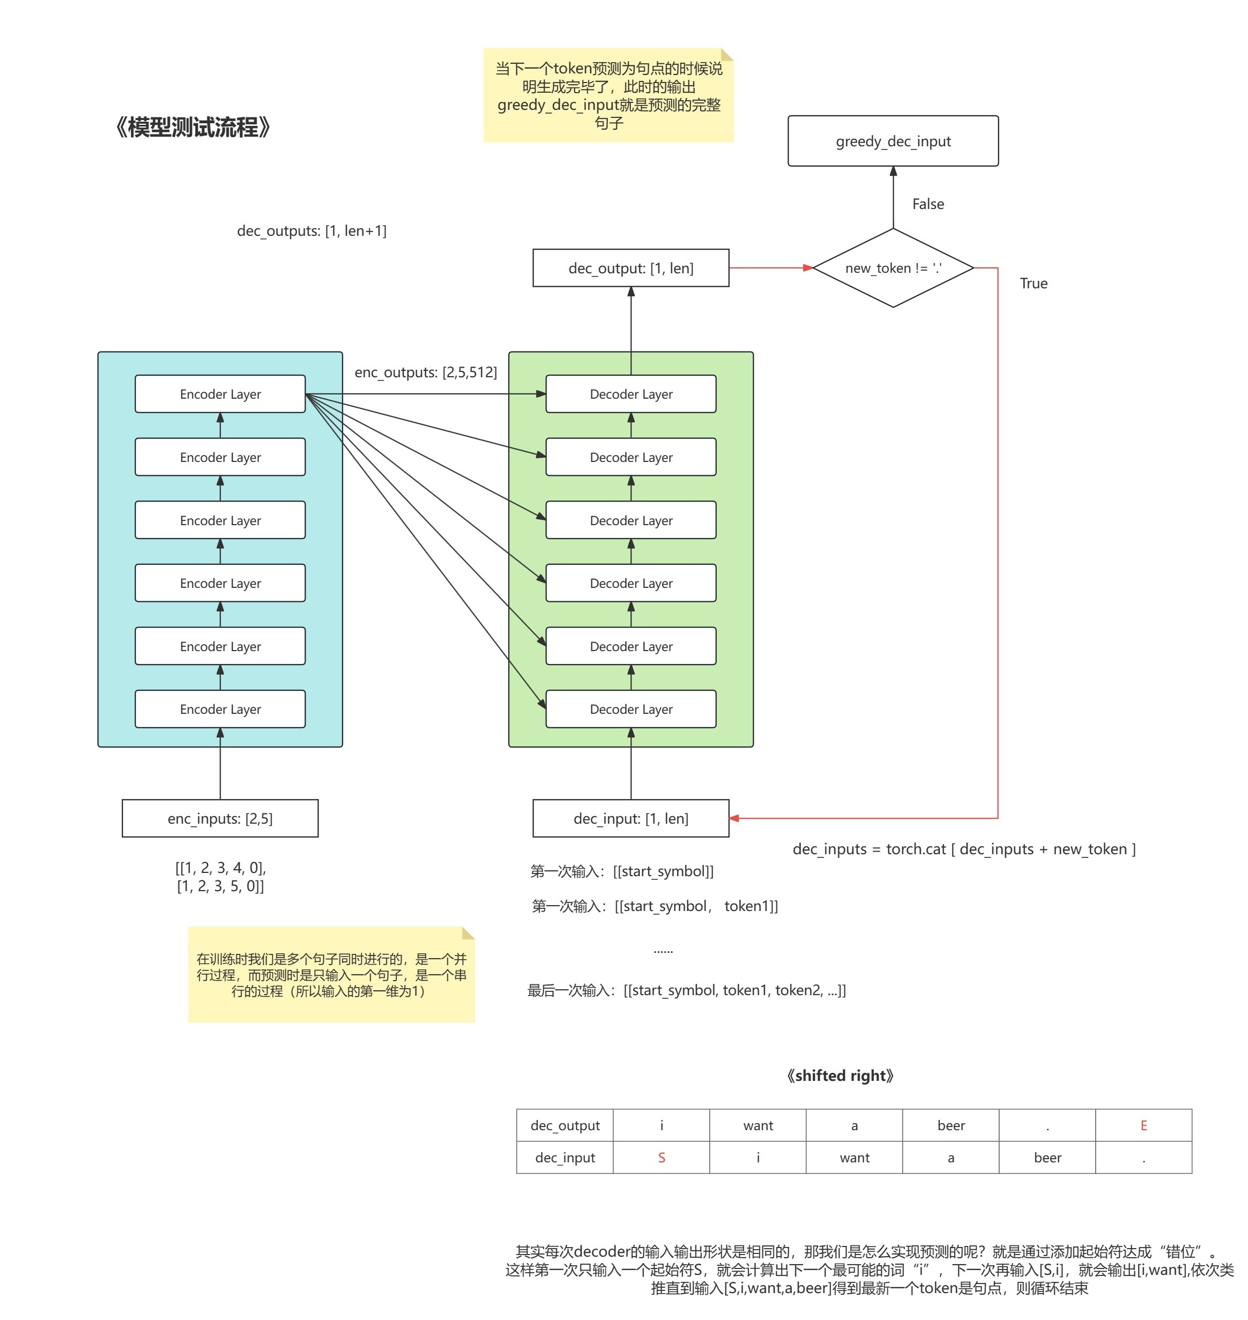

# 附1：对注意力分头的探究

In [57]:
# 探究一下多头注意力从(batch_size, seq_len, d_model) 到 (batch_size,n_heads, seq_len, d_k/v)的意义

# 1、这是初始的q
q = torch.arange(120).reshape(2,5,12)
print(q)
print('------------------')
batch_size = 2
seq_len = 5
d_model = 12
n_heads = 3
d_k = 4

# 2、分成n_heads个头
new_q = q.view(batch_size, -1, n_heads, d_k).transpose(1,2)
# 上面一行代码的形状变化：(2,5,12) -> (2,5,3,4) -> (2,3,5,4)
# 意义变化：最初是batch_size为2，一个batch中有2个句子，一个句子包含5个词，每个词由长度为12的向量表示
# 最后仍然是batch_size为2，但一个batch中有3个头，每个头包含一个句子，每个句子包含5个词，但每个词由长度为4的向量表示

print(new_q)
print(new_q.shape) # torch.Size([2, 3, 5, 4])
print('------------------')

# 3、将n_heads个头合并
final_q = q.transpose(1,2).contiguous().view(batch_size, -1, d_model)
print(final_q)
print(final_q.shape)
print('------------------')

# 按原来的concat实现拼回去元素顺序和最初不同了，因此改成下面这种实现
final_q2 = torch.cat([new_q[:,i,:,:] for i in range(new_q.size(1))], dim=-1)
print(final_q2)
print(final_q2.shape)

# 


tensor([[[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11],
         [ 12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23],
         [ 24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35],
         [ 36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47],
         [ 48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59]],

        [[ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71],
         [ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83],
         [ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95],
         [ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107],
         [108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]]])
------------------
tensor([[[[  0,   1,   2,   3],
          [ 12,  13,  14,  15],
          [ 24,  25,  26,  27],
          [ 36,  37,  38,  39],
          [ 48,  49,  50,  51]],

         [[  4,   5,   6,   7],
          [ 16,  17,  18,  19],
          [ 28,  29,  30,  31],
         

# 附2：模型中的数据流动

![Transformer_structure](./MyTransformer_pics/Transformer_structure.jpg)